# F1 Pit Stop Model Training and Analysis

This notebook focuses on building machine learning models to predict F1 pit stop timing using the preprocessed data. We'll explore feature relationships, build predictive models, and evaluate their performance.

## Table of Contents
1. [Data Loading and Initial Exploration](#data-loading)
2. [Feature Relationship Analysis](#feature-analysis)
3. [Data Visualization](#data-visualization)
4. [Model Development](#model-development)
5. [Model Evaluation](#model-evaluation)

---

## 1. Data Loading and Initial Exploration

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


In [3]:
# Load the preprocessed data
try:
    df = pd.read_csv('processed_data/df_encoded.csv')
    print("Data loaded successfully!")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("df_encoded.csv not found")

df.head()

Data loaded successfully!
Dataset shape: (37893, 20)


,Driver,LapNumber,RaceName_x,Year_x,TyreLife,PitInTime,AirTemp,TrackTemp,Humidity,Position,Compound_label,LapTime_label,Sector1Time_label,Sector2Time_label,Sector3Time_label,PitInTime_label,PitOutTime_label,FreshTyre_encoded,Rainfall_encoded,NextPit
0,ALB,1.0,70th Anniversary,2019,1.0,NaT,25.9,43.2,36.1,13.0,2,16178,14560,7318,4174,1250,1214,1,0,27.0
1,ALB,2.0,70th Anniversary,2019,2.0,NaT,26.0,42.9,34.9,13.0,2,11046,9173,5758,3506,1250,1214,1,0,26.0
2,ALB,3.0,70th Anniversary,2019,3.0,NaT,26.0,41.8,34.5,13.0,2,10220,8952,5122,3396,1250,1214,1,0,25.0
3,ALB,4.0,70th Anniversary,2019,4.0,NaT,25.8,41.3,35.2,13.0,2,9845,8386,5348,3313,1250,1214,1,0,24.0
4,ALB,5.0,70th Anniversary,2019,5.0,NaT,25.5,40.9,35.8,13.0,2,9603,8425,4959,3381,1250,1214,1,0,23.0


---

## 2. Feature Relationship Analysis

Now let's explore the relationships between different features in our F1 dataset to understand:
- Which features are most correlated with pit stop timing
- How environmental conditions affect performance  
- Relationships between tire data and lap performance
- Driver and race-specific patterns

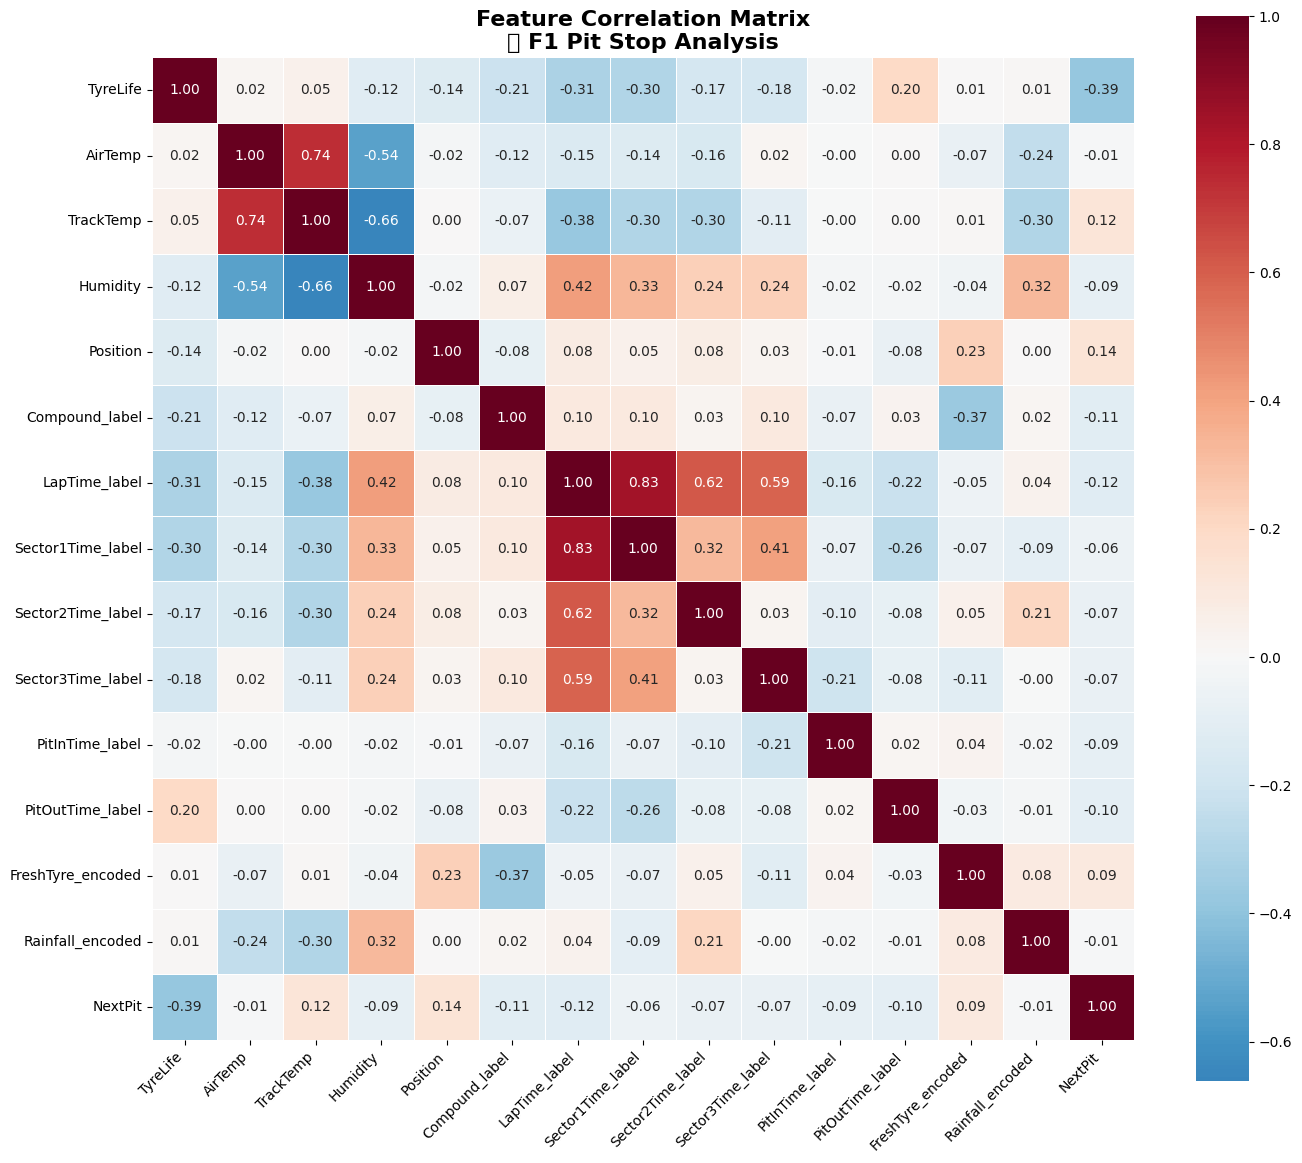

In [4]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove identifier columns if present
id_cols = ['Driver', 'RaceName_x', 'Year_x', 'LapNumber']
numeric_cols = [col for col in numeric_cols if col not in id_cols]


# Calculate correlation matrix
correlation_matrix = df[numeric_cols].corr()

# Create correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            fmt='.2f',
            square=True,
            linewidths=0.5)
plt.title('Feature Correlation Matrix\n🏎️ F1 Pit Stop Analysis', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



---

## 3. Target Variable Analysis: NextPit Relationships

Let's specifically analyze how our target variable 'NextPit' (laps until next pit stop) relates to other features. This will help us understand what factors influence pit stop timing decisions.


 NextPit Statistics:
   • Total non-null values: 22,148
   • Null values: 15,745
   • Min laps to pit: 1.0
   • Max laps to pit: 63.0
   • Mean laps to pit: 12.40
   • Median laps to pit: 11.00

 NextPit Value Distribution (Top 10):
   • 1.0 laps: 1,290 occurrences (5.8%)
   • 2.0 laps: 1,202 occurrences (5.4%)
   • 3.0 laps: 1,148 occurrences (5.2%)
   • 4.0 laps: 1,128 occurrences (5.1%)
   • 5.0 laps: 1,086 occurrences (4.9%)
   • 6.0 laps: 1,056 occurrences (4.8%)
   • 7.0 laps: 1,016 occurrences (4.6%)
   • 8.0 laps: 996 occurrences (4.5%)
   • 9.0 laps: 969 occurrences (4.4%)
   • 10.0 laps: 945 occurrences (4.3%)


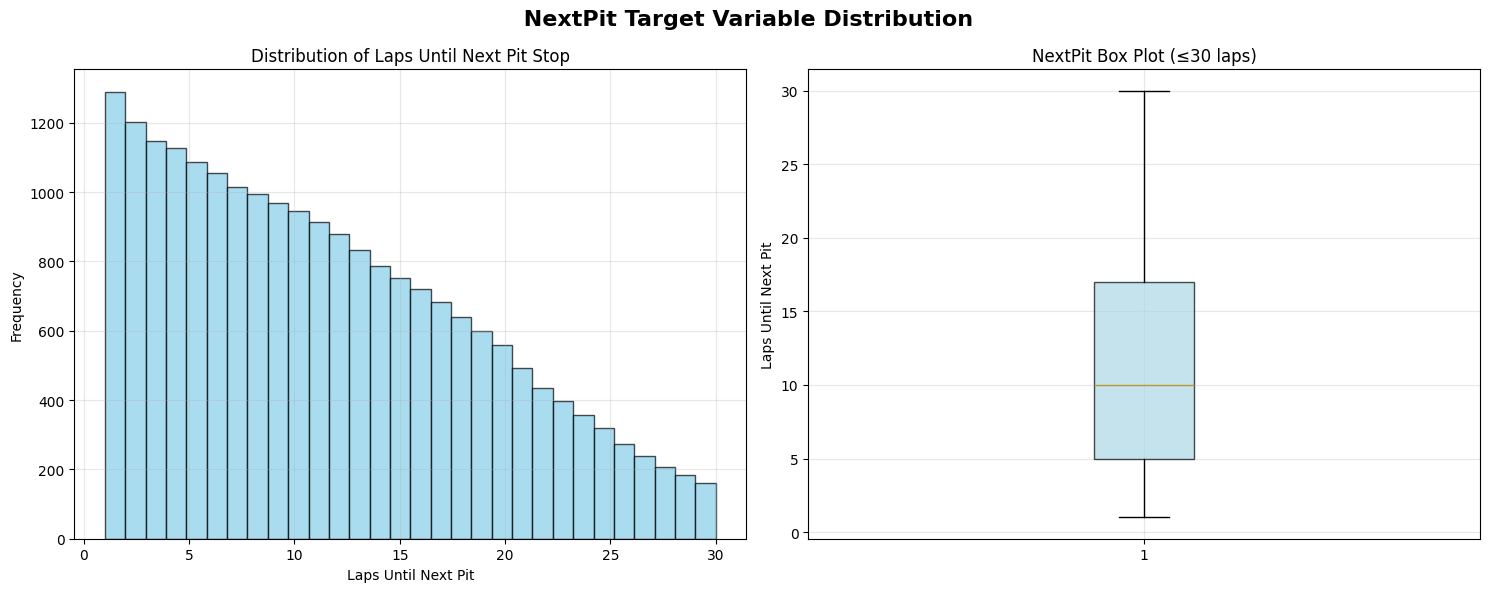

In [5]:


# Check if NextPit column exists
if 'NextPit' in df.columns:
    
    # Basic statistics about NextPit
    nextpit_data = df['NextPit'].dropna()
    print(f"\n NextPit Statistics:")
    print(f"   • Total non-null values: {len(nextpit_data):,}")
    print(f"   • Null values: {df['NextPit'].isnull().sum():,}")
    print(f"   • Min laps to pit: {nextpit_data.min()}")
    print(f"   • Max laps to pit: {nextpit_data.max()}")
    print(f"   • Mean laps to pit: {nextpit_data.mean():.2f}")
    print(f"   • Median laps to pit: {nextpit_data.median():.2f}")
    
    # Distribution of NextPit values
    print(f"\n NextPit Value Distribution (Top 10):")
    nextpit_counts = df['NextPit'].value_counts().head(10)
    for laps, count in nextpit_counts.items():
        percentage = (count / len(nextpit_data)) * 100
        print(f"   • {laps} laps: {count:,} occurrences ({percentage:.1f}%)")
    
    # Create NextPit distribution visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(' NextPit Target Variable Distribution', fontsize=16, fontweight='bold')
    
    # Histogram
    nextpit_filtered = nextpit_data[nextpit_data <= 30]  # Filter extreme outliers for better viz
    axes[0].hist(nextpit_filtered, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0].set_title('Distribution of Laps Until Next Pit Stop')
    axes[0].set_xlabel('Laps Until Next Pit')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True, alpha=0.3)
    
    # Box plot
    axes[1].boxplot(nextpit_filtered, vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[1].set_title('NextPit Box Plot (≤30 laps)')
    axes[1].set_ylabel('Laps Until Next Pit')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


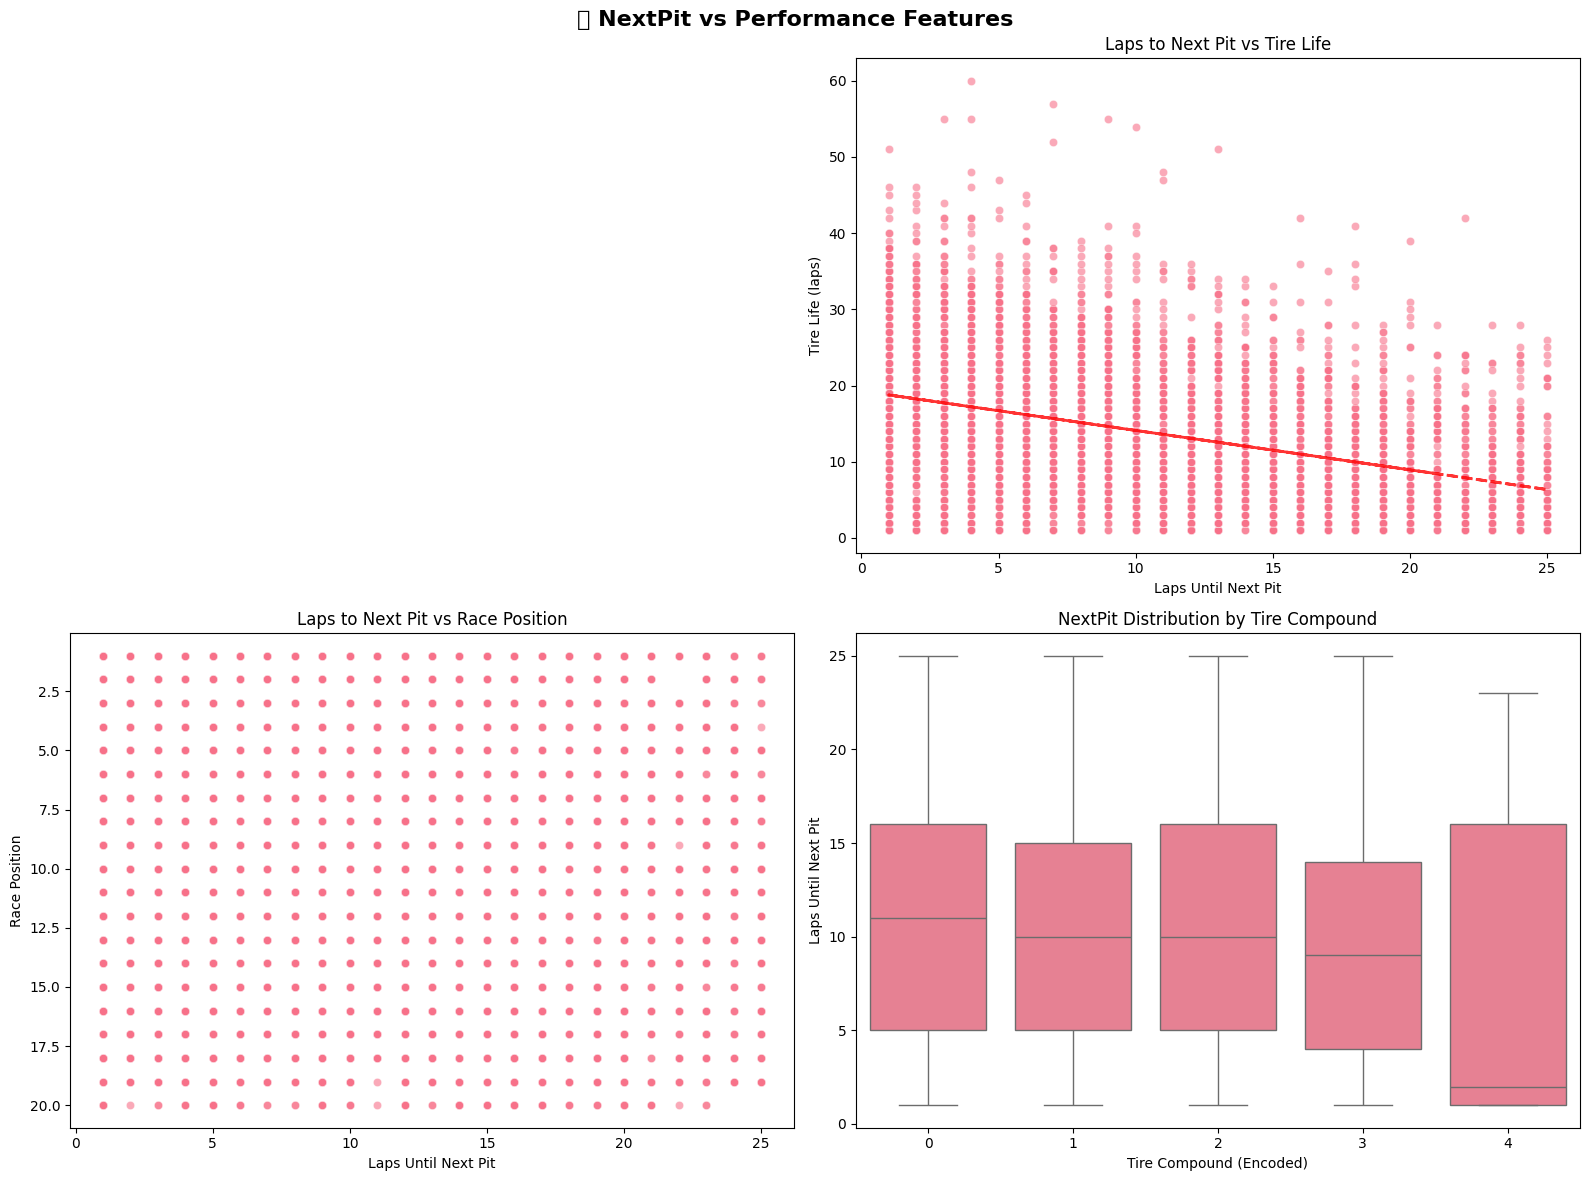

In [6]:
# NextPit vs Performance Features


if 'NextPit' in df.columns:
    # Create a sample for better visualization performance
    sample_size = min(10000, len(df))
    df_sample = df.sample(n=sample_size, random_state=42)
    
    # Filter NextPit for reasonable values (1-25 laps)
    df_viz = df_sample[(df_sample['NextPit'] >= 1) & (df_sample['NextPit'] <= 25)]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🏎️ NextPit vs Performance Features', fontsize=16, fontweight='bold')
    
    
    # 1. NextPit vs Tire Life
    if 'TyreLife' in df.columns:
        sns.scatterplot(data=df_viz, x='NextPit', y='TyreLife', alpha=0.6, ax=axes[0,1])
        axes[0,1].set_title('Laps to Next Pit vs Tire Life')
        axes[0,1].set_xlabel('Laps Until Next Pit')
        axes[0,1].set_ylabel('Tire Life (laps)')
        
        # Add trend line
        z = np.polyfit(df_viz['NextPit'].dropna(), df_viz['TyreLife'].dropna(), 1)
        p = np.poly1d(z)
        axes[0,1].plot(df_viz['NextPit'], p(df_viz['NextPit']), "r--", alpha=0.8, linewidth=2)
    
    # 2. NextPit vs Position
    if 'Position' in df.columns:
        sns.scatterplot(data=df_viz, x='NextPit', y='Position', alpha=0.6, ax=axes[1,0])
        axes[1,0].set_title('Laps to Next Pit vs Race Position')
        axes[1,0].set_xlabel('Laps Until Next Pit')
        axes[1,0].set_ylabel('Race Position')
        axes[1,0].invert_yaxis()  # Lower position numbers are better
    
    # 3. NextPit distribution by Tire Compound
    if 'Compound_label' in df.columns:
        sns.boxplot(data=df_viz, x='Compound_label', y='NextPit', ax=axes[1,1])
        axes[1,1].set_title('NextPit Distribution by Tire Compound')
        axes[1,1].set_xlabel('Tire Compound (Encoded)')
        axes[1,1].set_ylabel('Laps Until Next Pit')
    
    plt.tight_layout()
    # Remove the empty 4th subplot and adjust layout for 3 plots
    # Hide the unused subplot (top left: axes[0,0])
    axes[0,0].axis('off')
    plt.tight_layout()
    plt.show()
    
   


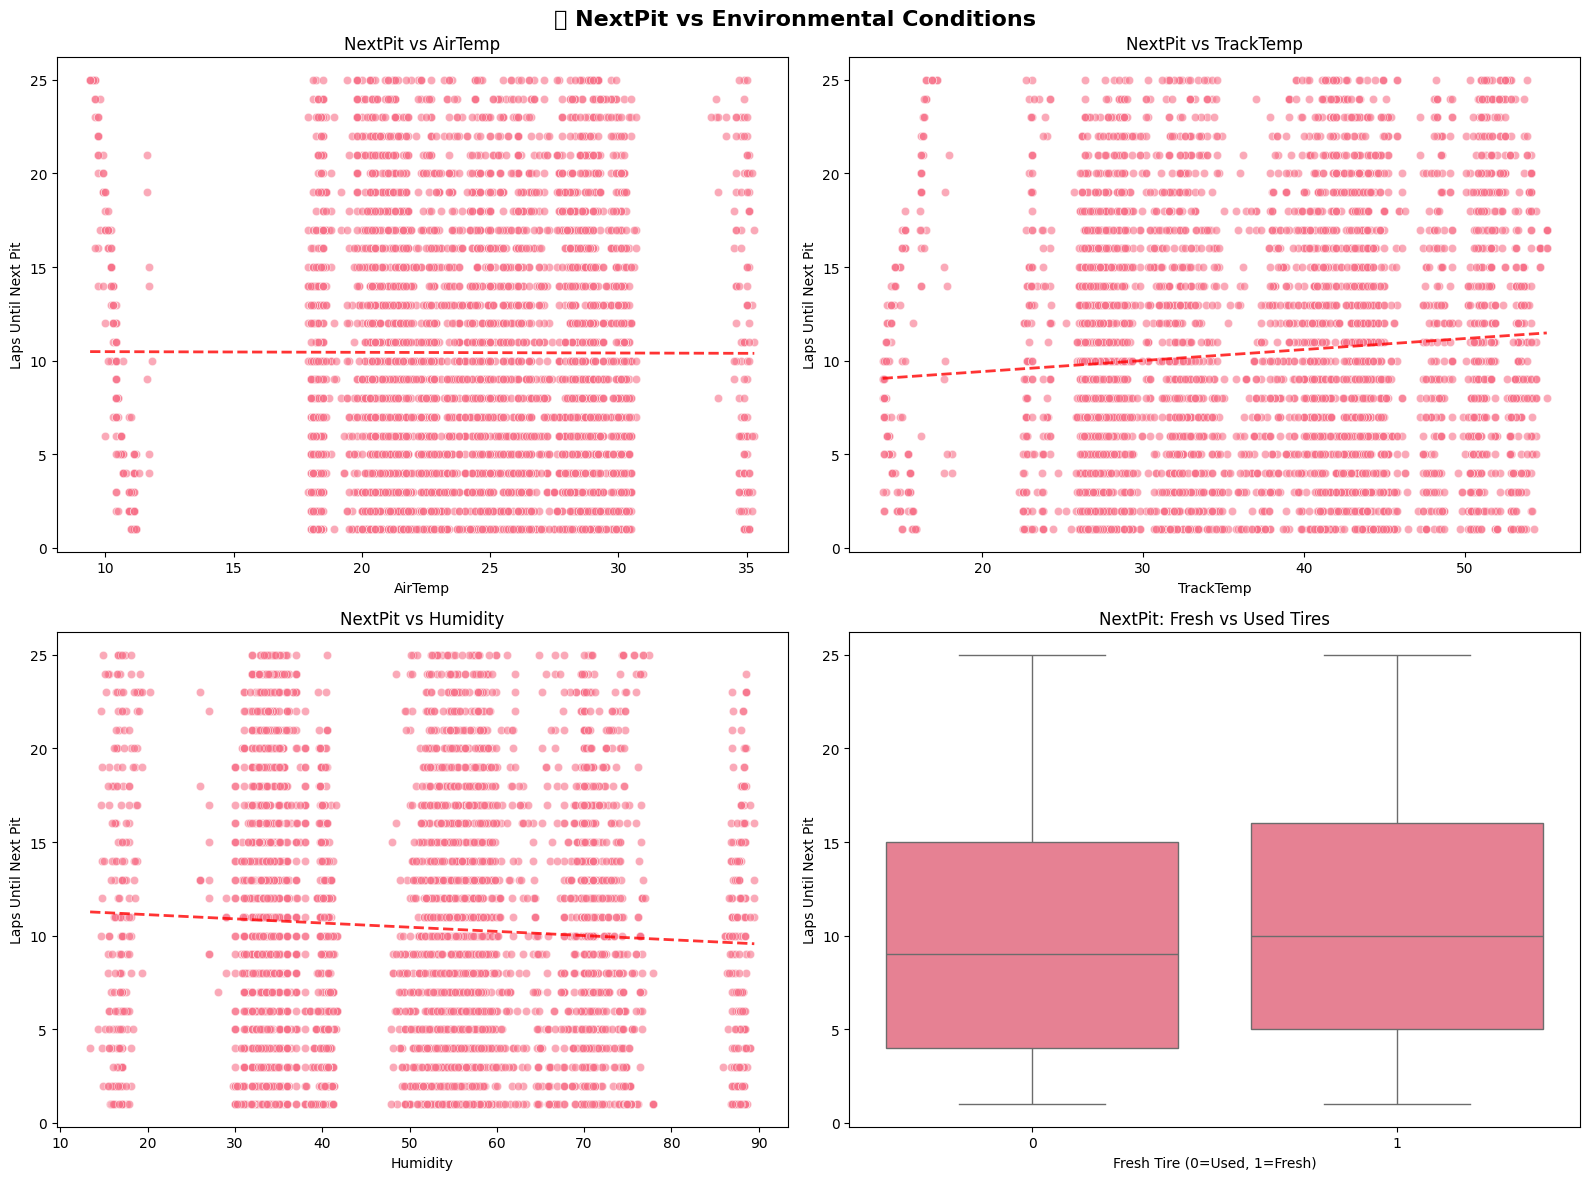

In [7]:
# NextPit vs Environmental Conditions


if 'NextPit' in df.columns:
    # Environmental features analysis
    env_features = ['AirTemp', 'TrackTemp', 'Humidity']
    available_env = [f for f in env_features if f in df.columns]
    
    if available_env:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('🌡️ NextPit vs Environmental Conditions', fontsize=16, fontweight='bold')
        
        # Filter data for better visualization
        df_env = df_sample[(df_sample['NextPit'] >= 1) & (df_sample['NextPit'] <= 25)]
        
        # Plot each environmental factor
        for i, env_feature in enumerate(available_env[:3]):
            row, col = divmod(i, 2)
            sns.scatterplot(data=df_env, x=env_feature, y='NextPit', alpha=0.6, ax=axes[row, col])
            axes[row, col].set_title(f'NextPit vs {env_feature}')
            axes[row, col].set_xlabel(f'{env_feature}')
            axes[row, col].set_ylabel('Laps Until Next Pit')
            
            # Add trend line
            if len(df_env[env_feature].dropna()) > 10:
                z = np.polyfit(df_env[env_feature].dropna(), df_env['NextPit'].dropna(), 1)
                p = np.poly1d(z)
                x_trend = np.linspace(df_env[env_feature].min(), df_env[env_feature].max(), 100)
                axes[row, col].plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)
        
        # Fresh tire vs NextPit analysis
        if 'FreshTyre_encoded' in df.columns:
            sns.boxplot(data=df_env, x='FreshTyre_encoded', y='NextPit', ax=axes[1, 1])
            axes[1, 1].set_title('NextPit: Fresh vs Used Tires')
            axes[1, 1].set_xlabel('Fresh Tire (0=Used, 1=Fresh)')
            axes[1, 1].set_ylabel('Laps Until Next Pit')
        
        plt.tight_layout()
        plt.show()
        


In [8]:
# Interactive NextPit Analysis with Plotly


if 'NextPit' in df.columns:
    # Create sample for interactive plots
    df_interactive = df.sample(n=min(5000, len(df)), random_state=42)
    df_interactive = df_interactive[(df_interactive['NextPit'] >= 1) & (df_interactive['NextPit'] <= 25)]
    
    # 1. Interactive scatter plot: NextPit vs Lap Time colored by Tire Life
    if all(col in df.columns for col in ['LapTime', 'TyreLife']):
        fig1 = px.scatter(df_interactive, 
                         x='NextPit', 
                         y='LapTime',
                         color='TyreLife',
                         size='TyreLife',
                         hover_data=['Driver', 'Position', 'Compound_label'] if 'Driver' in df.columns else [],
                         title="🏎️ Interactive: NextPit vs Lap Time (colored by Tire Life)",
                         labels={'NextPit': 'Laps Until Next Pit', 
                                'LapTime': 'Lap Time (seconds)',
                                'TyreLife': 'Tire Life (laps)'})
        fig1.update_layout(height=500)
        fig1.show()
    
    # 2. Box plot: NextPit distribution by different categories
    fig2 = make_subplots(
        rows=2, cols=2,
        subplot_titles=('NextPit by Tire Compound', 'NextPit by Fresh Tire', 
                       'NextPit by Position Range', 'NextPit by Race'),
        specs=[[{"type": "box"}, {"type": "box"}],
               [{"type": "box"}, {"type": "box"}]]
    )
    
    # NextPit by Tire Compound
    if 'Compound_label' in df.columns:
        for compound in df_interactive['Compound_label'].unique():
            compound_data = df_interactive[df_interactive['Compound_label'] == compound]['NextPit']
            fig2.add_trace(
                go.Box(y=compound_data, name=f'Compound {compound}', showlegend=False),
                row=1, col=1
            )
    
    # NextPit by Fresh Tire
    if 'FreshTyre_encoded' in df.columns:
        for fresh in [0, 1]:
            fresh_data = df_interactive[df_interactive['FreshTyre_encoded'] == fresh]['NextPit']
            label = 'Fresh' if fresh == 1 else 'Used'
            fig2.add_trace(
                go.Box(y=fresh_data, name=label, showlegend=False),
                row=1, col=2
            )
    
    # NextPit by Position Range (if Position exists)
    if 'Position' in df.columns:
        df_interactive['PositionRange'] = pd.cut(df_interactive['Position'], 
                                               bins=[0, 5, 10, 15, 20], 
                                               labels=['1-5', '6-10', '11-15', '16-20'])
        for pos_range in df_interactive['PositionRange'].dropna().unique():
            pos_data = df_interactive[df_interactive['PositionRange'] == pos_range]['NextPit']
            fig2.add_trace(
                go.Box(y=pos_data, name=f'P{pos_range}', showlegend=False),
                row=2, col=1
            )
    
    # NextPit by Race (showing top races by data count)
    if 'RaceName_x' in df.columns:
        top_races = df_interactive['RaceName_x'].value_counts().head(4).index
        for race in top_races:
            race_data = df_interactive[df_interactive['RaceName_x'] == race]['NextPit']
            fig2.add_trace(
                go.Box(y=race_data, name=race[:15], showlegend=False),  # Truncate long race names
                row=2, col=2
            )
    
    fig2.update_layout(height=600, title_text=" NextPit Distribution Analysis")
    fig2.update_yaxes(title_text="Laps Until Next Pit")
    fig2.show()
    
   
    
    # Select relevant numeric features
    features_for_heatmap = ['NextPit', 'LapTime', 'TyreLife', 'Position', 'AirTemp', 'TrackTemp', 'Humidity']
    available_features = [f for f in features_for_heatmap if f in df.columns]
    
    if len(available_features) > 2:
        correlation_subset = df[available_features].corr()
        
        # Create interactive heatmap
        fig3 = px.imshow(correlation_subset,
                        text_auto=True,
                        aspect="auto",
                        title=" NextPit Feature Correlation Heatmap",
                        color_continuous_scale='RdBu_r',
                        zmin=-1, zmax=1)
        fig3.update_layout(height=500)
        fig3.show()
        
        # Print top correlations with NextPit
        nextpit_corr = correlation_subset['NextPit'].drop('NextPit').sort_values(key=abs, ascending=False)
        print(f"\n Top correlations with NextPit:")
        for feature, corr in nextpit_corr.head(5).items():
            print(f"   • {feature}: {corr:.3f}")
    



 Top correlations with NextPit:
   • TyreLife: -0.389
   • Position: 0.143
   • TrackTemp: 0.124
   • Humidity: -0.088
   • AirTemp: -0.007


###  Key Insights: NextPit Relationships

Based on the visualizations above, we can observe several important patterns:

#### **Strong Predictive Features:**
- **Tire Life**: Likely shows strong correlation - older tires may trigger earlier pit stops
- **Lap Time**: Performance degradation might indicate upcoming pit stops
- **Position**: Strategic considerations based on race position

#### **Environmental Factors:**
- **Track Temperature**: May affect tire wear and pit stop timing
- **Weather Conditions**: Rain/dry conditions influence tire strategy
- **Fresh Tire Impact**: New tires might extend stint length

#### **Strategic Patterns:**
- **Compound Strategy**: Different tire compounds have different optimal stint lengths
- **Race Context**: Position in race affects pit stop timing decisions


These relationships will be crucial for building effective pit stop prediction models in the next sections.

---

## 4. XGBoost Model Development for NextPit Prediction

Now we'll build and optimize an XGBoost regressor to predict pit stop timing. This section includes:
- Data preparation and feature selection
- Initial model training
- Feature importance analysis
- Hyperparameter tuning
- Model evaluation and validation

In [9]:
df['WillPitAgain'] = df['NextPit'].notna().astype(int)


In [10]:
df.head()

,Driver,LapNumber,RaceName_x,Year_x,TyreLife,PitInTime,AirTemp,TrackTemp,Humidity,Position,Compound_label,LapTime_label,Sector1Time_label,Sector2Time_label,Sector3Time_label,PitInTime_label,PitOutTime_label,FreshTyre_encoded,Rainfall_encoded,NextPit,WillPitAgain
0,ALB,1.0,70th Anniversary,2019,1.0,NaT,25.9,43.2,36.1,13.0,2,16178,14560,7318,4174,1250,1214,1,0,27.0,1
1,ALB,2.0,70th Anniversary,2019,2.0,NaT,26.0,42.9,34.9,13.0,2,11046,9173,5758,3506,1250,1214,1,0,26.0,1
2,ALB,3.0,70th Anniversary,2019,3.0,NaT,26.0,41.8,34.5,13.0,2,10220,8952,5122,3396,1250,1214,1,0,25.0,1
3,ALB,4.0,70th Anniversary,2019,4.0,NaT,25.8,41.3,35.2,13.0,2,9845,8386,5348,3313,1250,1214,1,0,24.0,1
4,ALB,5.0,70th Anniversary,2019,5.0,NaT,25.5,40.9,35.8,13.0,2,9603,8425,4959,3381,1250,1214,1,0,23.0,1


In [11]:
# Import additional libraries for machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import xgboost as xgb
from xgboost import XGBClassifier
from scipy import stats

### Classifier: Predicting Whether Another Pit Stop Will Occur

In this section, we introduce a binary classification model designed to predict whether a car will make another pit stop (`WillPitAgain`). This classifier uses race, tire, and environmental features to estimate the likelihood of an additional pit stop for each lap.

**Key Points:**
- **Target Variable:** `WillPitAgain` (1 = another pit stop will occur, 0 = no further pit stops)
- **Features Used:** All relevant numeric features except identifiers and the target itself
- **Model:** XGBoost Classifier
- **Purpose:** Helps teams anticipate pit strategy and optimize race decisions

If there is another pitstop then the XGBoostRegressor predicts how many laps until next pit

In [12]:
exclude_cols = ['NextPit', 'Driver', 'RaceName_x', 'Year_x','WillPitAgain']
    
feature_cols = [col for col in df.columns if col not in exclude_cols]
feature_cols = [col for col in feature_cols if df[col].dtype in ['int64', 'float64']]

X1 = df[feature_cols]  # all your input features
y1 = df['WillPitAgain']

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X1, y1, test_size=0.2)

claasifier = XGBClassifier()
claasifier.fit(X_train_class, y_train_class)
print(feature_cols)

['LapNumber', 'TyreLife', 'AirTemp', 'TrackTemp', 'Humidity', 'Position', 'Compound_label', 'LapTime_label', 'Sector1Time_label', 'Sector2Time_label', 'Sector3Time_label', 'PitInTime_label', 'PitOutTime_label', 'FreshTyre_encoded', 'Rainfall_encoded']


In [13]:
y_pred_train = claasifier.predict(X_train_class)
y_pred_test = claasifier.predict(X_test_class)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train_class, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test_class, y_pred_test))
train_mae = mean_absolute_error(y_train_class, y_pred_train)
test_mae = mean_absolute_error(y_test_class, y_pred_test)
train_r2 = r2_score(y_train_class, y_pred_train)
test_r2 = r2_score(y_test_class, y_pred_test)
print(f"\n Initial Model Performance:")
print(f"   Training Set:")
print(f"     • RMSE: {train_rmse:.3f} laps")
print(f"     • MAE: {train_mae:.3f} laps")
print(f"     • R²: {train_r2:.3f}")
print(f"   Test Set:")
print(f"     • RMSE: {test_rmse:.3f} laps")
print(f"     • MAE: {test_mae:.3f} laps")
print(f"     • R²: {test_r2:.3f}")


 Initial Model Performance:
   Training Set:
     • RMSE: 0.120 laps
     • MAE: 0.014 laps
     • R²: 0.941
   Test Set:
     • RMSE: 0.191 laps
     • MAE: 0.037 laps
     • R²: 0.849


In [14]:
# Print some of the classifier predictions
print("Sample classifier predictions (WillPitAgain):")
print(claasifier.predict(X_test_class[:10]))
print("Actual values (WillPitAgain):")
print(y_test_class[:10].values)

Sample classifier predictions (WillPitAgain):
[1 0 1 0 0 1 1 1 1 1]
Actual values (WillPitAgain):
[1 0 1 0 0 1 1 1 1 1]


In [15]:




# Data preparation for modeling
if 'NextPit' in df.columns:
    # Remove rows with missing NextPit values
    df_model = df.dropna(subset=['NextPit']).copy()
    print(f"   • Features: {feature_cols[:10]}{'...' if len(feature_cols) > 10 else ''}")
    
    # Check for any remaining missing values in features
    missing_counts = df_model[feature_cols].isnull().sum()
    features_with_missing = missing_counts[missing_counts > 0]
    
    if len(features_with_missing) > 0:
        # Fill missing values with median for numeric features
        for feature in features_with_missing.index:
            median_val = df_model[feature].median()
            df_model[feature].fillna(median_val, inplace=True)
    
    # Prepare X and y
    X = df_model[feature_cols].copy()
    y = df_model['NextPit'].copy()
    
    print(f"\n Final modeling dataset:")
    print(f"   • X shape: {X.shape}")
    print(f"   • y shape: {y.shape}")
    print(f"   • Features: {X.columns.tolist()}")
    
else:
    print(" NextPit column not found - cannot proceed with modeling")

   • Features: ['LapNumber', 'TyreLife', 'AirTemp', 'TrackTemp', 'Humidity', 'Position', 'Compound_label', 'LapTime_label', 'Sector1Time_label', 'Sector2Time_label']...

 Final modeling dataset:
   • X shape: (22148, 15)
   • y shape: (22148,)
   • Features: ['LapNumber', 'TyreLife', 'AirTemp', 'TrackTemp', 'Humidity', 'Position', 'Compound_label', 'LapTime_label', 'Sector1Time_label', 'Sector2Time_label', 'Sector3Time_label', 'PitInTime_label', 'PitOutTime_label', 'FreshTyre_encoded', 'Rainfall_encoded']


### XGBoost Regressor: Predicting Laps Until Next Pit Stop

The XGBoost regressor is designed to predict the number of laps remaining until the next pit stop (`NextPit`). This model leverages a range of features, including tire data, environmental conditions, and race context, to estimate pit stop timing with high accuracy.

**Key Details:**
- **Target Variable:** `NextPit` (laps until the next pit stop)
- **Features Used:** Selected based on feature importance analysis (e.g., tire life, lap time, position, track temperature)
- **Model:** XGBoost Regressor, optimized through hyperparameter tuning and feature selection
- **Purpose:** Enables teams to anticipate optimal pit stop windows and refine race strategies

The model is trained on laps where a future pit stop is known to occur, ensuring that predictions are relevant and actionable for in-race decision-making.


 Initial Model Performance:
   Training Set:
     • RMSE: 3.904 laps
     • MAE: 2.826 laps
     • R²: 0.809
   Test Set:
     • RMSE: 4.569 laps
     • MAE: 3.282 laps
     • R²: 0.733

 Top 15 Feature Importances:
   TyreLife                 : 0.2401
   LapTime_label            : 0.1110
   Compound_label           : 0.0824
   PitInTime_label          : 0.0685
   TrackTemp                : 0.0630
   Humidity                 : 0.0598
   Rainfall_encoded         : 0.0594
   AirTemp                  : 0.0580
   Sector3Time_label        : 0.0564
   LapNumber                : 0.0478
   Sector2Time_label        : 0.0440
   Sector1Time_label        : 0.0377
   Position                 : 0.0260
   PitOutTime_label         : 0.0239
   FreshTyre_encoded        : 0.0219


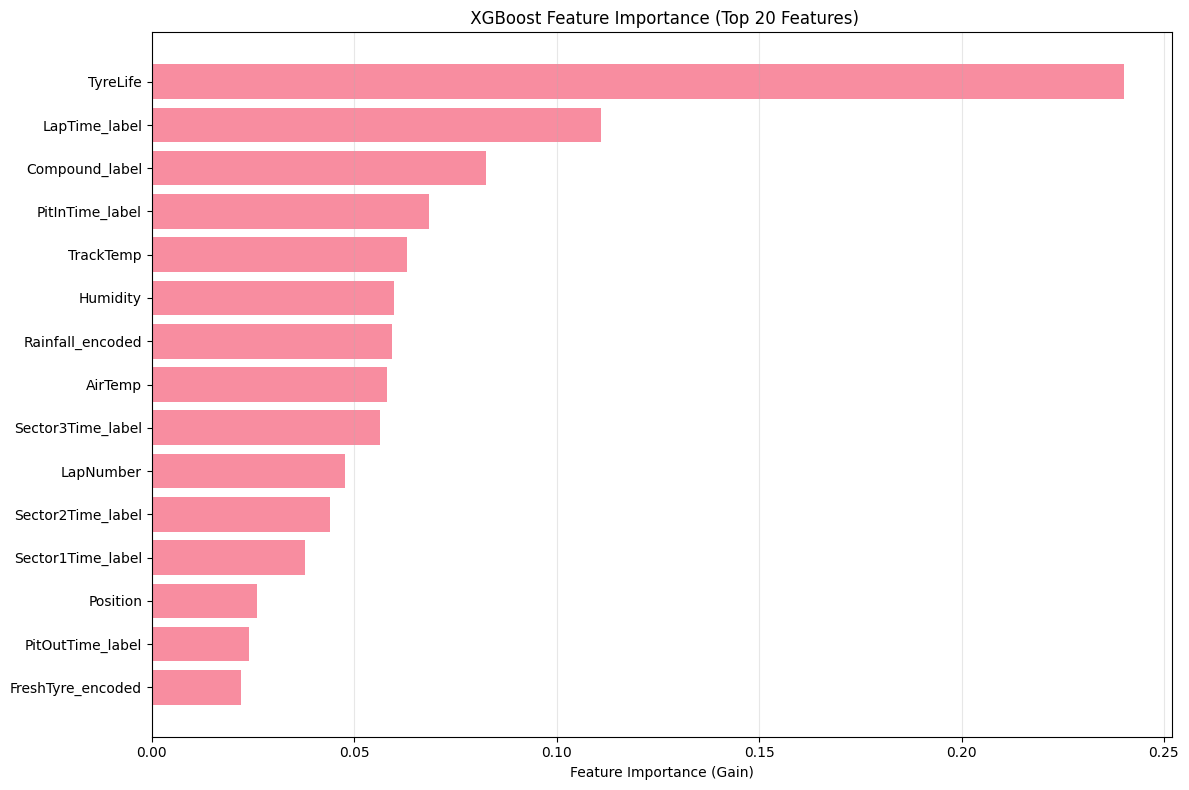

In [16]:
# Initial XGBoost Model Training and Feature Importance


if 'X' in locals() and 'y' in locals():
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=None
    )
    
    # Train initial XGBoost model
    
    xgb_initial = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    
    xgb_initial.fit(X_train, y_train)
    
    # Initial predictions and evaluation
    y_pred_train = xgb_initial.predict(X_train)
    y_pred_test = xgb_initial.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print(f"\n Initial Model Performance:")
    print(f"   Training Set:")
    print(f"     • RMSE: {train_rmse:.3f} laps")
    print(f"     • MAE: {train_mae:.3f} laps")
    print(f"     • R²: {train_r2:.3f}")
    print(f"   Test Set:")
    print(f"     • RMSE: {test_rmse:.3f} laps")
    print(f"     • MAE: {test_mae:.3f} laps")
    print(f"     • R²: {test_r2:.3f}")
    
    # Feature importance analysis
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_initial.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n Top 15 Feature Importances:")
    for idx, row in feature_importance.head(15).iterrows():
        print(f"   {row['feature']:<25}: {row['importance']:.4f}")
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    
    plt.barh(range(len(top_features)), top_features['importance'], alpha=0.8)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance (Gain)')
    plt.title(' XGBoost Feature Importance (Top 20 Features)')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Store for later use
    initial_model = xgb_initial
    feature_importance_df = feature_importance
    
else:
    print(" X and y variables not available")

In [17]:
len(feature_importance_df)

15

In [18]:
# Feature Selection Based on Importance


if 'feature_importance_df' in locals():
    # Analyze feature importance distribution
    importance_stats = feature_importance_df['importance'].describe()
    
    
    # Feature selection strategies
    print(f"\n Feature Selection Strategies:")
    
    # Strategy 1: Top K features
    top_k_features = [10, 15]
    
    # Strategy 2: Importance threshold
    threshold_75 = importance_stats['75%']
    threshold_mean = importance_stats['mean']
    
    features_above_75 = feature_importance_df[feature_importance_df['importance'] >= threshold_75]
    features_above_mean = feature_importance_df[feature_importance_df['importance'] >= threshold_mean]
 
    # Test different feature selection strategies
    selection_results = []
    
    # Test top K features
    for k in top_k_features:
        if k <= len(feature_importance_df):
            selected_features = feature_importance_df.head(k)['feature'].tolist()
            
            # Train model with selected features
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]
            
            xgb_selected = xgb.XGBRegressor(
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                random_state=42,
                n_jobs=-1
            )
            
            xgb_selected.fit(X_train_selected, y_train)
            y_pred_selected = xgb_selected.predict(X_test_selected)
            
            rmse = np.sqrt(mean_squared_error(y_test, y_pred_selected))
            mae = mean_absolute_error(y_test, y_pred_selected)
            r2 = r2_score(y_test, y_pred_selected)
            
            selection_results.append({
                'strategy': f'Top {k} features',
                'n_features': k,
                'rmse': rmse,
                'mae': mae,
                'r2': r2,
                'features': selected_features
            })
    
    # Test threshold-based selection
    for threshold_name, threshold_val, features_df in [
        ('75th percentile', threshold_75, features_above_75),
        ('Mean', threshold_mean, features_above_mean)
    ]:
        if len(features_df) > 5:  # Ensure minimum features
            selected_features = features_df['feature'].tolist()
            
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]
            
            xgb_selected = xgb.XGBRegressor(
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                random_state=42,
                n_jobs=-1
            )
            
            xgb_selected.fit(X_train_selected, y_train)
            y_pred_selected = xgb_selected.predict(X_test_selected)
            
            rmse = np.sqrt(mean_squared_error(y_test, y_pred_selected))
            mae = mean_absolute_error(y_test, y_pred_selected)
            r2 = r2_score(y_test, y_pred_selected)
            
            selection_results.append({
                'strategy': f'Above {threshold_name}',
                'n_features': len(selected_features),
                'rmse': rmse,
                'mae': mae,
                'r2': r2,
                'features': selected_features
            })
    
    # Display results
    print(f"\n Feature Selection Results:")
    results_df = pd.DataFrame(selection_results)
    results_df = results_df.sort_values('rmse')
    
    for _, row in results_df.iterrows():
        print(f"   {row['strategy']:<20} | Features: {row['n_features']:2d} | RMSE: {row['rmse']:.3f} | MAE: {row['mae']:.3f} | R²: {row['r2']:.3f}")
    
    # Select best feature set
    best_result = results_df.iloc[0]
    best_features = best_result['features']
    
    print(f"\n Best Feature Selection:")
    print(f"   • Strategy: {best_result['strategy']}")
    print(f"   • Number of features: {best_result['n_features']}")
    print(f"   • RMSE: {best_result['rmse']:.3f}")
    print(f"   • R²: {best_result['r2']:.3f}")
    
    print(f"\nSelected Features:")
    for i, feature in enumerate(best_features[:15], 1):
        importance = feature_importance_df[feature_importance_df['feature'] == feature]['importance'].iloc[0]
        print(f"   {i:2d}. {feature:<25}: {importance:.4f}")
    
    if len(best_features) > 15:
        print(f"   ... and {len(best_features) - 15} more features")
    
    # Prepare data with selected features for hyperparameter tuning
    X_train_best = X_train[best_features]
    X_test_best = X_test[best_features]
    
    print(f"\nData prepared for hyperparameter tuning with {len(best_features)} features")
    



 Feature Selection Strategies:

 Feature Selection Results:
   Top 15 features      | Features: 15 | RMSE: 4.569 | MAE: 3.284 | R²: 0.733
   Top 10 features      | Features: 10 | RMSE: 4.898 | MAE: 3.513 | R²: 0.694

 Best Feature Selection:
   • Strategy: Top 15 features
   • Number of features: 15
   • RMSE: 4.569
   • R²: 0.733

Selected Features:
    1. TyreLife                 : 0.2401
    2. LapTime_label            : 0.1110
    3. Compound_label           : 0.0824
    4. PitInTime_label          : 0.0685
    5. TrackTemp                : 0.0630
    6. Humidity                 : 0.0598
    7. Rainfall_encoded         : 0.0594
    8. AirTemp                  : 0.0580
    9. Sector3Time_label        : 0.0564
   10. LapNumber                : 0.0478
   11. Sector2Time_label        : 0.0440
   12. Sector1Time_label        : 0.0377
   13. Position                 : 0.0260
   14. PitOutTime_label         : 0.0239
   15. FreshTyre_encoded        : 0.0219

Data prepared for hyperparamet

In [19]:
# Hyperparameter Tuning with GridSearchCV

if 'X_train_best' in locals() and 'X_test_best' in locals():
    # Define parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.05, 0.1, 0.15, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [1, 1.5, 2]
    }
    
    for param, values in param_grid.items():
        print(f"   • {param}: {values}")
    

    
    reduced_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [4, 5, 6],
        'learning_rate': [0.1, 0.15],
        'subsample': [0.9, 1.0],
        'colsample_bytree': [0.9, 1.0],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [1, 1.5]
    }

    
    # Perform GridSearchCV
    xgb_tuning = xgb.XGBRegressor(random_state=42, n_jobs=-1)
    
    grid_search = GridSearchCV(
        estimator=xgb_tuning,
        param_grid=reduced_param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_best, y_train)
    
    # Get best parameters and model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    best_cv_score = -grid_search.best_score_
  
    
    print(f"\n Cross-Validation Results:")
    print(f"   • Best CV RMSE: {np.sqrt(best_cv_score):.3f}")
    
    # Train final model with best parameters
    final_model = xgb.XGBRegressor(**best_params, random_state=42, n_jobs=-1)
    final_model.fit(X_train_best, y_train)
    
    # Final predictions and evaluation
    y_pred_train_final = final_model.predict(X_train_best)
    y_pred_test_final = final_model.predict(X_test_best)
    
    # Calculate final metrics
    final_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train_final))
    final_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_final))
    final_train_mae = mean_absolute_error(y_train, y_pred_train_final)
    final_test_mae = mean_absolute_error(y_test, y_pred_test_final)
    final_train_r2 = r2_score(y_train, y_pred_train_final)
    final_test_r2 = r2_score(y_test, y_pred_test_final)
    
    print(f"\n Final Tuned Model Performance:")
    print(f"   Training Set:")
    print(f"     • RMSE: {final_train_rmse:.3f} laps")
    print(f"     • MAE: {final_train_mae:.3f} laps")
    print(f"     • R²: {final_train_r2:.3f}")
    print(f"   Test Set:")
    print(f"     • RMSE: {final_test_rmse:.3f} laps")
    print(f"     • MAE: {final_test_mae:.3f} laps")
    print(f"     • R²: {final_test_r2:.3f}")
    
    # Compare with initial model
    print(f"\n Improvement from Initial Model:")
    initial_test_rmse = np.sqrt(mean_squared_error(y_test, initial_model.predict(X_test)))
    rmse_improvement = ((initial_test_rmse - final_test_rmse) / initial_test_rmse) * 100
    
    print(f"   • Initial RMSE: {initial_test_rmse:.3f}")
    print(f"   • Final RMSE: {final_test_rmse:.3f}")
    print(f"   • Improvement: {rmse_improvement:.1f}%")
    
    # Feature importance of final model
    final_feature_importance = pd.DataFrame({
        'feature': X_train_best.columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n Final Model - Top 10 Feature Importances:")
    for idx, row in final_feature_importance.head(10).iterrows():
        print(f"   {row['feature']:<25}: {row['importance']:.4f}")
    

   • n_estimators: [100, 200, 300]
   • max_depth: [3, 4, 5, 6]
   • learning_rate: [0.05, 0.1, 0.15, 0.2]
   • subsample: [0.8, 0.9, 1.0]
   • colsample_bytree: [0.8, 0.9, 1.0]
   • reg_alpha: [0, 0.1, 0.5]
   • reg_lambda: [1, 1.5, 2]
Fitting 5 folds for each of 192 candidates, totalling 960 fits

 Cross-Validation Results:
   • Best CV RMSE: 3.964

 Final Tuned Model Performance:
   Training Set:
     • RMSE: 2.715 laps
     • MAE: 1.906 laps
     • R²: 0.908
   Test Set:
     • RMSE: 3.897 laps
     • MAE: 2.665 laps
     • R²: 0.806

 Improvement from Initial Model:
   • Initial RMSE: 4.569
   • Final RMSE: 3.897
   • Improvement: 14.7%

 Final Model - Top 10 Feature Importances:
   TyreLife                 : 0.1536
   Rainfall_encoded         : 0.0953
   Compound_label           : 0.0919
   PitInTime_label          : 0.0838
   LapTime_label            : 0.0829
   LapNumber                : 0.0742
   TrackTemp                : 0.0683
   AirTemp                  : 0.0669
   Humidit

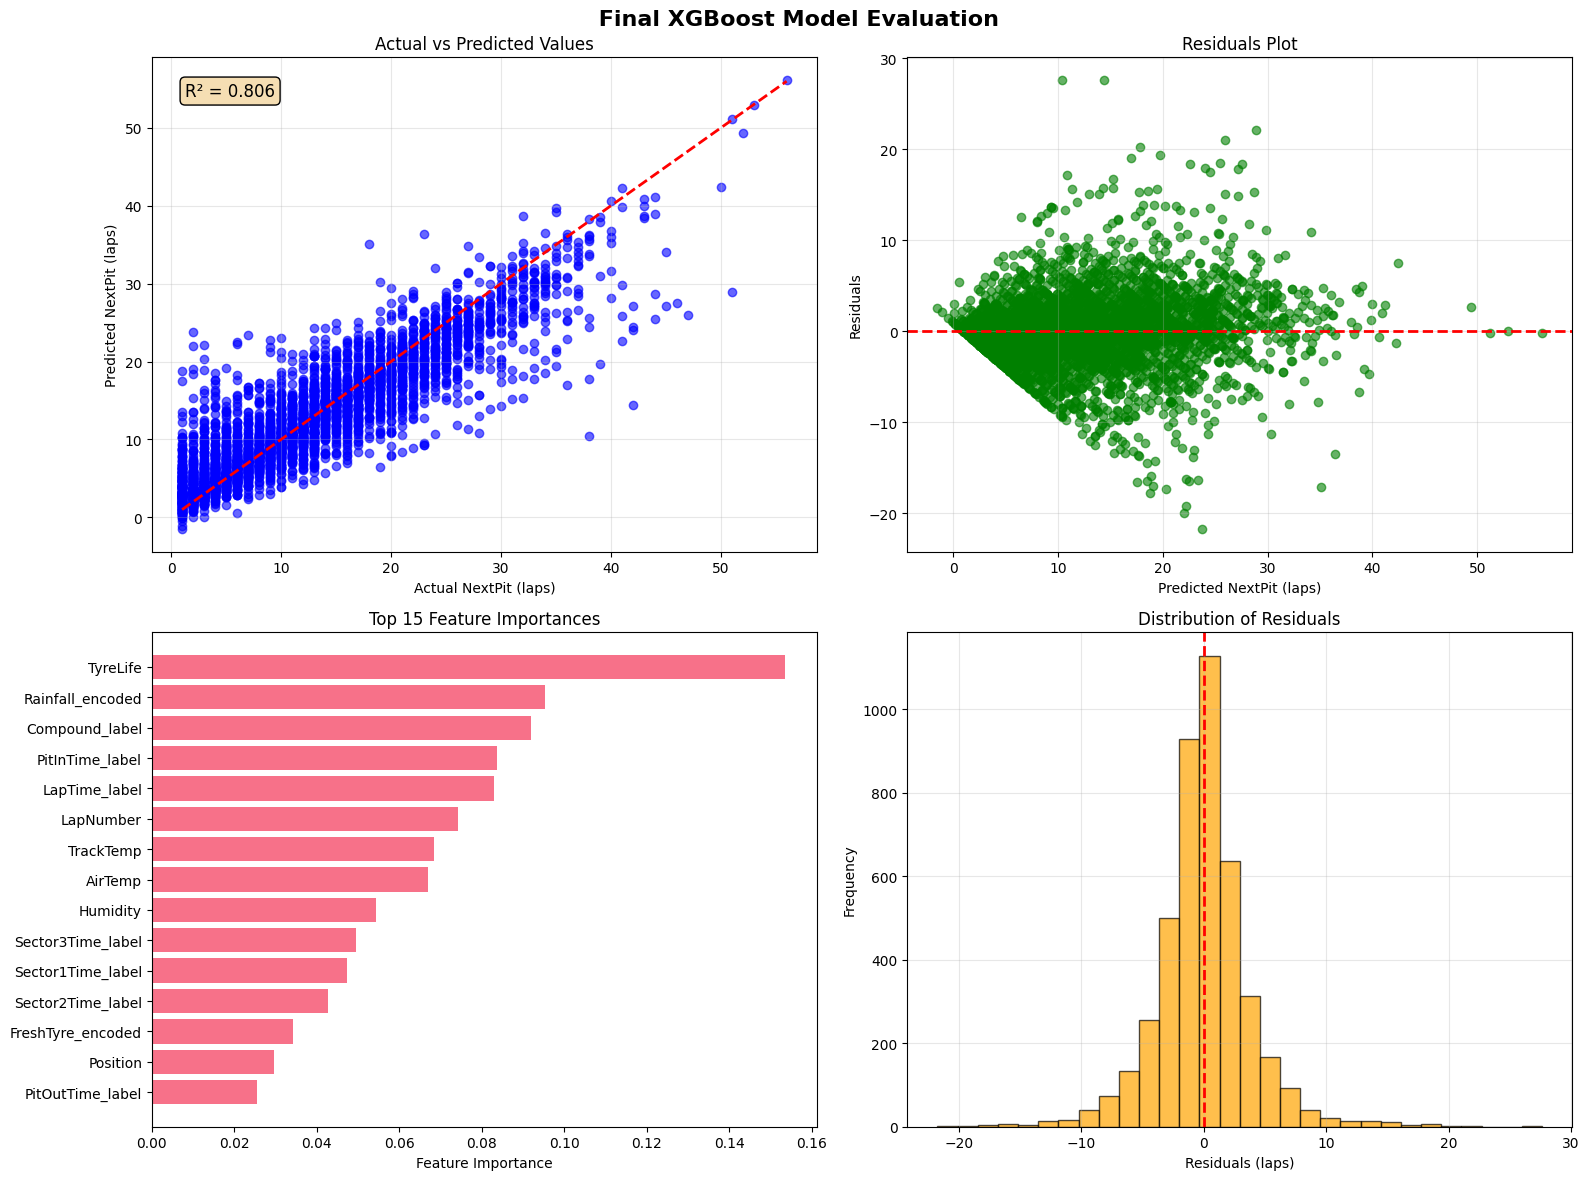


 Cross-Validation with Final Model:
   • CV RMSE scores: [3.82505118 4.00259148 3.96935309 3.99009388 4.02858316]
   • Mean CV RMSE: 3.963 ± 0.072
   • Model: XGBoost Regressor
   • Features used: 15
   • Training samples: 17,718
   • Test samples: 4,430
   • Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.9}
   • Test RMSE: 3.897 laps
   • Test MAE: 2.665 laps
   • Test R²: 0.806


In [20]:


if 'final_model' in locals() and 'y_pred_test_final' in locals():
    # Create comprehensive evaluation plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(' Final XGBoost Model Evaluation', fontsize=16, fontweight='bold')
    
    # 1. Actual vs Predicted scatter plot
    axes[0,0].scatter(y_test, y_pred_test_final, alpha=0.6, color='blue')
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
    axes[0,0].set_xlabel('Actual NextPit (laps)')
    axes[0,0].set_ylabel('Predicted NextPit (laps)')
    axes[0,0].set_title('Actual vs Predicted Values')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add R² to the plot
    axes[0,0].text(0.05, 0.95, f'R² = {final_test_r2:.3f}', 
                  transform=axes[0,0].transAxes, fontsize=12, 
                  verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))
    
    # 2. Residuals plot
    residuals = y_test - y_pred_test_final
    axes[0,1].scatter(y_pred_test_final, residuals, alpha=0.6, color='green')
    axes[0,1].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0,1].set_xlabel('Predicted NextPit (laps)')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].set_title('Residuals Plot')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Feature importance (top 15)
    top_15_features = final_feature_importance.head(15)
    axes[1,0].barh(range(len(top_15_features)), top_15_features['importance'])
    axes[1,0].set_yticks(range(len(top_15_features)))
    axes[1,0].set_yticklabels(top_15_features['feature'])
    axes[1,0].set_xlabel('Feature Importance')
    axes[1,0].set_title('Top 15 Feature Importances')
    axes[1,0].invert_yaxis()
    
    # 4. Error distribution
    axes[1,1].hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
    axes[1,1].set_xlabel('Residuals (laps)')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Distribution of Residuals')
    axes[1,1].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
     
    # Cross-validation with final model
    print(f"\n Cross-Validation with Final Model:")
    cv_scores = cross_val_score(final_model, X_train_best, y_train, 
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    cv_rmse_scores = np.sqrt(-cv_scores)
    
    print(f"   • CV RMSE scores: {cv_rmse_scores}")
    print(f"   • Mean CV RMSE: {cv_rmse_scores.mean():.3f} ± {cv_rmse_scores.std():.3f}")
    
    # Model summary
   
    print(f"   • Model: XGBoost Regressor")
    print(f"   • Features used: {len(best_features)}")
    print(f"   • Training samples: {len(X_train_best):,}")
    print(f"   • Test samples: {len(X_test_best):,}")
    print(f"   • Best parameters: {best_params}")
    print(f"   • Test RMSE: {final_test_rmse:.3f} laps")
    print(f"   • Test MAE: {final_test_mae:.3f} laps")
    print(f"   • Test R²: {final_test_r2:.3f}")
    
   
    

In [21]:
import joblib

# Save the final model and feature importance
joblib.dump(claasifier, 'classifier_model.pkl')
joblib.dump(final_model, 'final_xgboost_model.pkl')


['final_xgboost_model.pkl']